*In the interest of time, I'll probably exlude this one.*

Do you think XKCD is cool and carry a sketch book to your workplace? Then you'll like `pygal`!

`pygal` advertises itself as "sexy data visualization", which is a bit weird. It has a notebook aesthetic by default; though this can be tuned at runtime, I wager the notebooky-feel is part of the appeal.

In [4]:
import pandas as pd
collisions = pd.read_csv("../data/NYPD_Motor_Vehicle_Collisions_2016.csv", index_col=0)

%matplotlib inline

In [28]:
import pygal

Here's our bog-standard bar chart done in `pygal`:

In [67]:
df = collisions['BOROUGH'].value_counts()

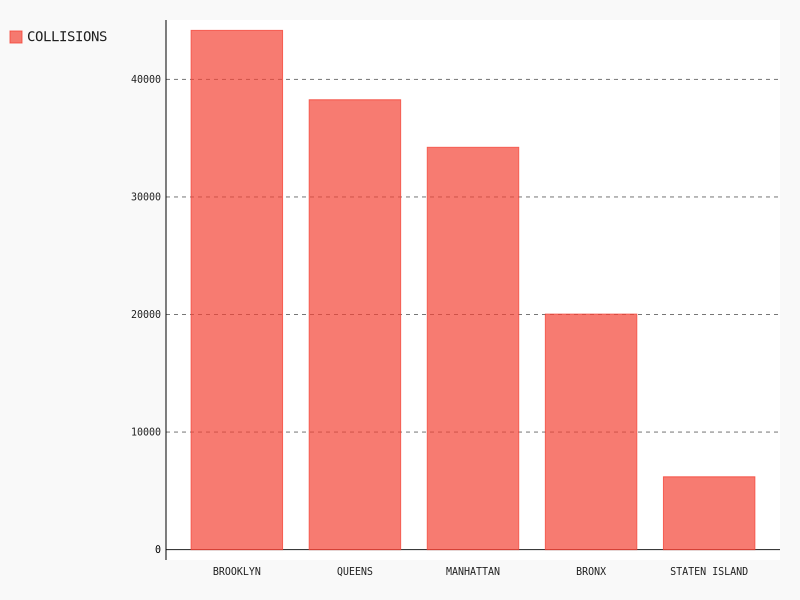

In [68]:
srs = collisions['BOROUGH'].value_counts()

fig = pygal.Bar()
fig.add('COLLISIONS', srs)  # Can also do (None, srs)
fig.x_labels = df.index.values

fig

The `pygal` API has interesting functional features. For example, instead of using `add` to get our data into the plot we can instead unpack our data into a `pygal.Bar` factory function:

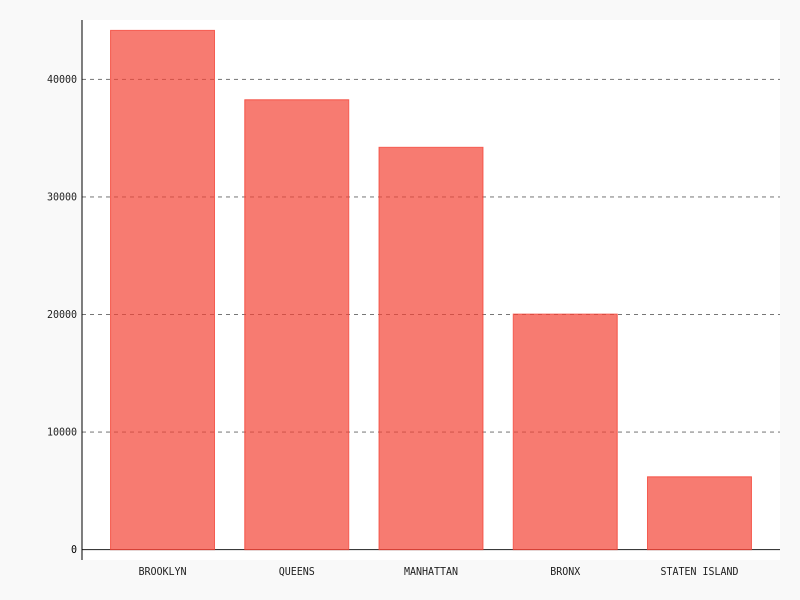

In [69]:
pygal.Bar(x_labels=list(df.index.values))(*srs)

In [76]:
df = (collisions
          .groupby(['CONTRIBUTING FACTOR VEHICLE 1', 'NUMBER OF PERSONS INJURED'])
          .count()
          .loc[:, 'DATE']
          .rename('COUNT(COLLISIONS)')
          .to_frame()
          .unstack('NUMBER OF PERSONS INJURED')
     )

df.columns = df.columns.droplevel(0)

df = (df.rename_axis("INJURIES", axis='columns')
        .rename_axis("CONTRIBUTING FACTOR", axis='rows')
        .apply(lambda srs: srs.drop(srs.iloc[3:].index.values), axis=1)
        .fillna(0)
        .drop("Unspecified")
        .sort_values(by=0, ascending=False)
        .head(5))
df.head()

INJURIES,0,1,2
CONTRIBUTING FACTOR,,,
Driver Inattention/Distraction,20704.0,3900.0,694.0
Failure to Yield Right-of-Way,5152.0,2002.0,357.0
Backing Unsafely,4614.0,350.0,30.0
Fatigued/Drowsy,4346.0,661.0,191.0
Following Too Closely,4029.0,822.0,233.0


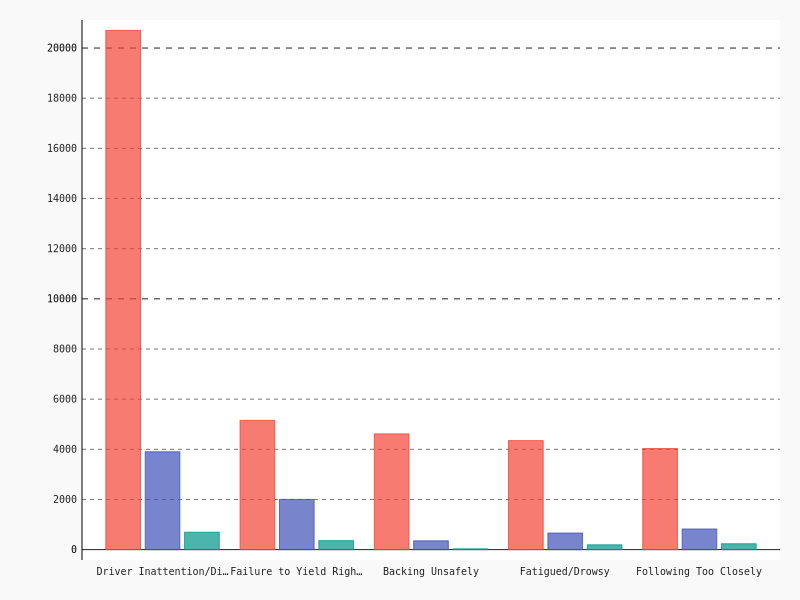

In [79]:
pygal.Bar(x_labels=list(df.index.values))(*df[0])(*df[1])(*df[2])

This is a really interesting API design choice; it appears that every chart in `pygal` can actually be written in a method chained functional way, a bit like what we saw with `ggplot` but replacing the `+` operator with more paren `()` function calls. However, it can also be written in the usual, `matplotlib`-like object-oriented way, and this appears to be how it is prescribed in its own documentation.

Lots to note here. Firstly, `pygal` was intended for web display. Hence it comes with bindings for using it within Django, Flask, and every output format you can shake your tail at, but only runs with limited interactivity when inside of a Jupyter notebook.

*Jump over to http://pygal.org/en/stable/documentation/first_steps.html to show what it looks like on the web.*

Secondly, `pygal` wasn't designed with the `numpy` API in mind (and, by extension, with `pandas` in mind). So while it generally works out fine, there's some weirdness, like the fact that we have to listify our index explicitly to get the x labels to display.

Finally, notice that it automatically hides text that's too long. That's a really simple but nice-to-have feature that tripped us up when we were using `seaborn`, for example.

The backend&mdash;what actually displays the chart&mdash;is pure SVG, via the `cairosvg` package.

Let's look at a few other plots.

First, a stacked line chart:

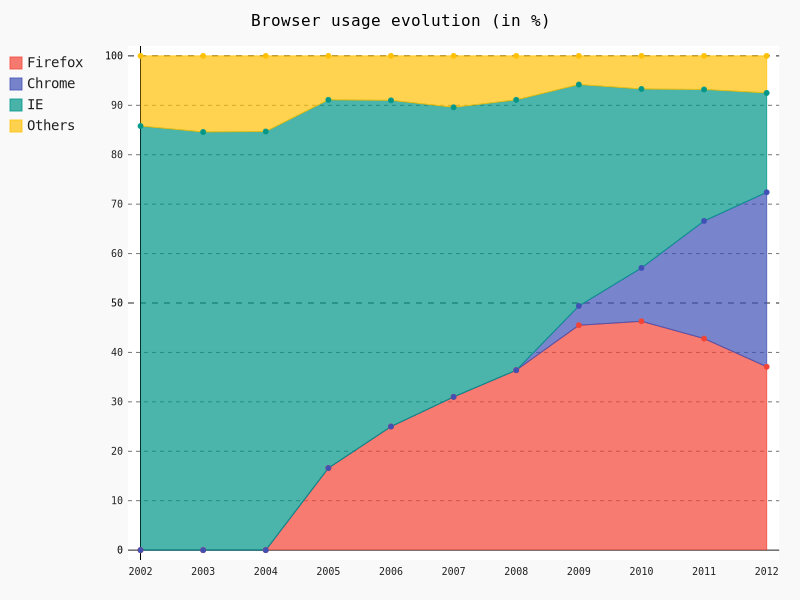

In [80]:
fig = pygal.StackedLine(fill=True)
fig.title = 'Browser usage evolution (in %)'
fig.x_labels = map(str, range(2002, 2013))
fig.add('Firefox', [None, None, 0, 16.6,   25,   31, 36.4, 45.5, 46.3, 42.8, 37.1])
fig.add('Chrome',  [None, None, None, None, None, None,    0,  3.9, 10.8, 23.8, 35.3])
fig.add('IE',      [85.8, 84.6, 84.7, 74.5,   66, 58.6, 54.7, 44.8, 36.2, 26.6, 20.1])
fig.add('Others',  [14.2, 15.4, 15.3,  8.9,    9, 10.4,  8.9,  5.8,  6.7,  6.8,  7.5])

fig

A pie chart. Though we haven't pointed them out before, `pandas` and `seaborn` both also provide pie charts, `ggpy` does not.

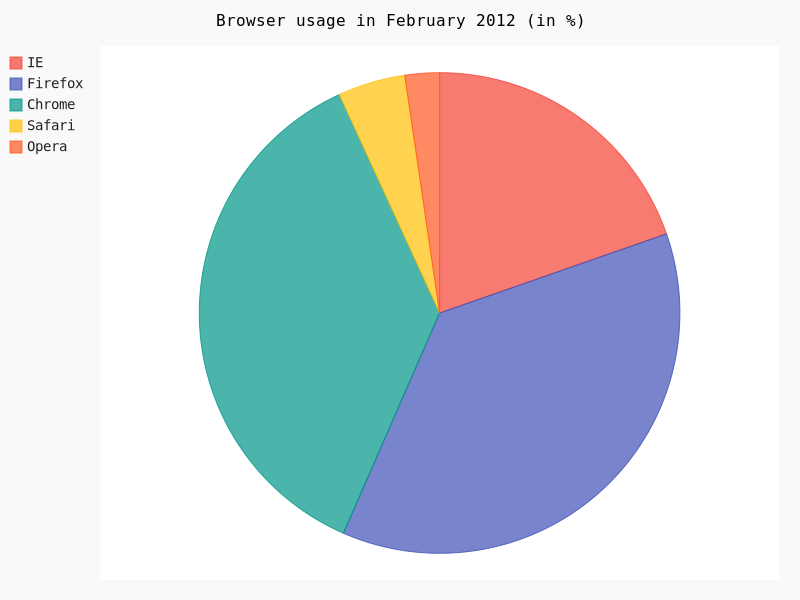

In [81]:
fig = pygal.Pie()
fig.title = 'Browser usage in February 2012 (in %)'
fig.add('IE', 19.5)
fig.add('Firefox', 36.6)
fig.add('Chrome', 36.3)
fig.add('Safari', 4.5)
fig.add('Opera', 2.3)

fig

A radar chart. None of our other libraries so far have this one because it's considered most unhelpful for data exploration; but it does look cool to end users, hence why a web-focused library like `pygal` has it.

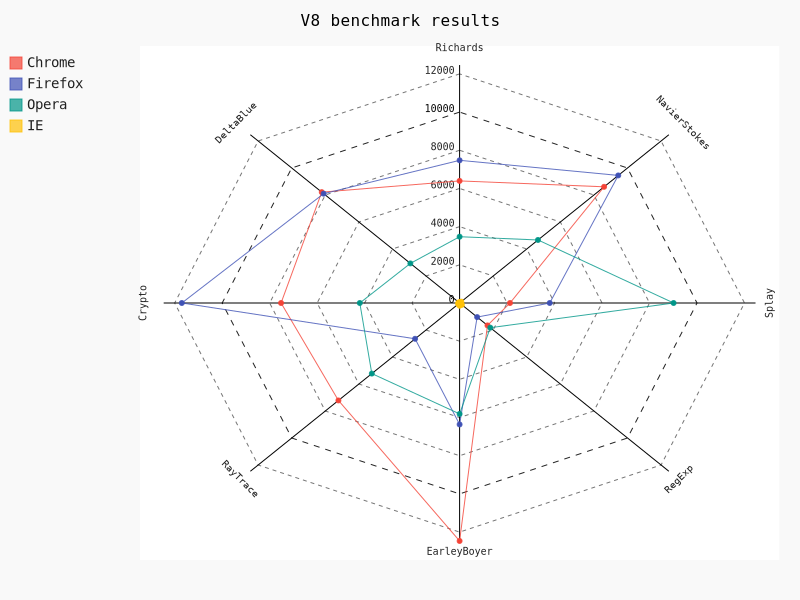

In [83]:
fig = pygal.Radar()
fig.title = 'V8 benchmark results'
fig.x_labels = ['Richards', 'DeltaBlue', 'Crypto', 'RayTrace', 'EarleyBoyer', 'RegExp', 'Splay', 'NavierStokes']
fig.add('Chrome', [6395, 8212, 7520, 7218, 12464, 1660, 2123, 8607])
fig.add('Firefox', [7473, 8099, 11700, 2651, 6361, 1044, 3797, 9450])
fig.add('Opera', [3472, 2933, 4203, 5229, 5810, 1828, 9013, 4669])
fig.add('IE', [43, 41, 59, 79, 144, 136, 34, 102])
fig.render()

fig

Box plots, with a number of different tailing options:

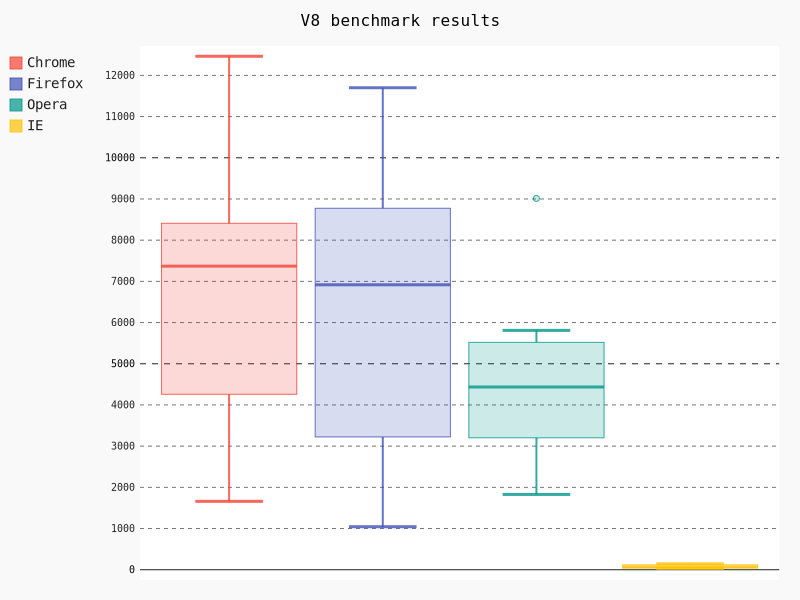

In [84]:
fig = pygal.Box(box_mode="tukey")
fig.title = 'V8 benchmark results'
fig.add('Chrome', [6395, 8212, 7520, 7218, 12464, 1660, 2123, 8607])
fig.add('Firefox', [7473, 8099, 11700, 2651, 6361, 1044, 3797, 9450])
fig.add('Opera', [3472, 2933, 4203, 5229, 5810, 1828, 9013, 4669])
fig.add('IE', [43, 41, 59, 79, 144, 136, 34, 102])

fig

Dot plots, another web-native methingamabobber. Popular with Tableau users, I hear.

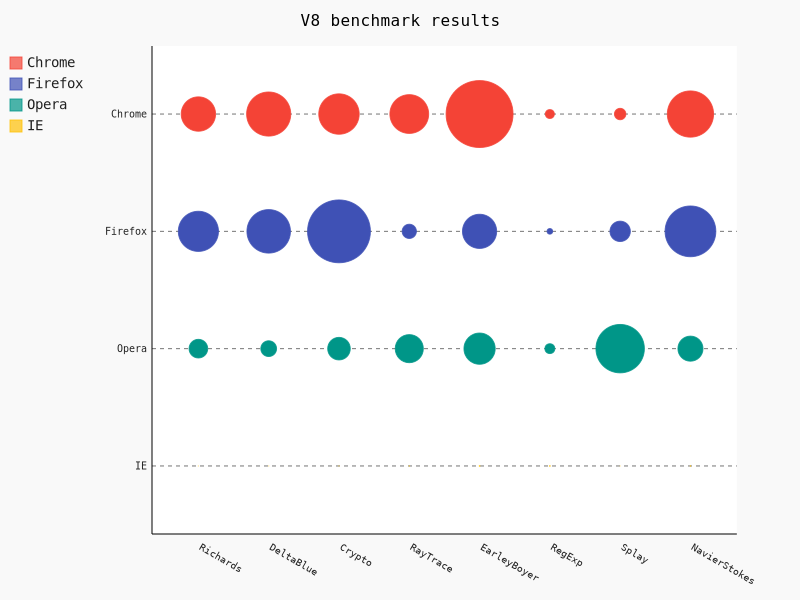

In [85]:
fig = pygal.Dot(x_label_rotation=30)
fig.title = 'V8 benchmark results'
fig.x_labels = ['Richards', 'DeltaBlue', 'Crypto', 'RayTrace', 'EarleyBoyer', 'RegExp', 'Splay', 'NavierStokes']
fig.add('Chrome', [6395, 8212, 7520, 7218, 12464, 1660, 2123, 8607])
fig.add('Firefox', [7473, 8099, 11700, 2651, 6361, 1044, 3797, 9450])
fig.add('Opera', [3472, 2933, 4203, 5229, 5810, 1828, 9013, 4669])
fig.add('IE', [43, 41, 59, 79, 144, 136, 34, 102])

fig

A treemap, which can actually be useful for visualizing up to two levels of hierarchy in categorical data. However, since `pygal` can't render the labels when running in a Jupyter notebook, the point is moot.

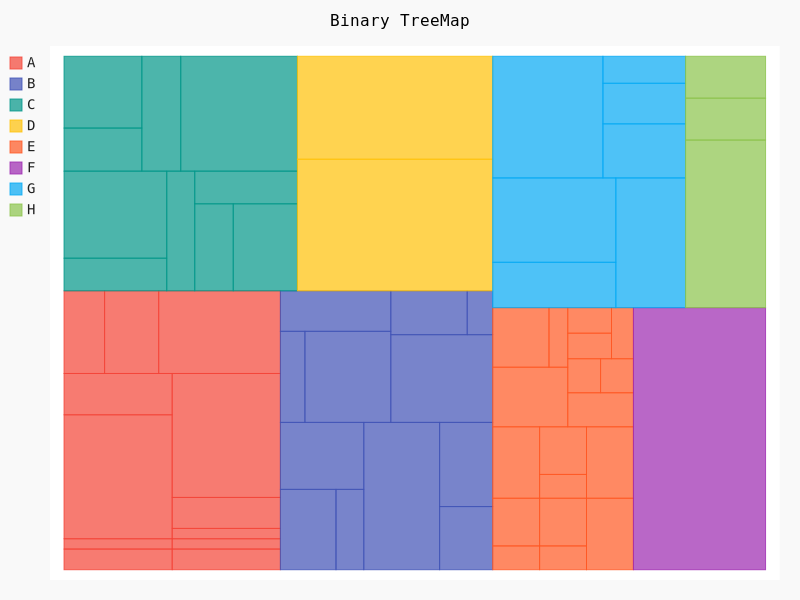

In [87]:
fig = pygal.Treemap()
fig.title = 'Binary TreeMap'
fig.add('A', [2, 1, 12, 4, 2, 1, 1, 3, 12, 3, 4, None, 9])
fig.add('B', [4, 2, 5, 10, 3, 4, 2, 7, 4, -10, None, 8, 3, 1])
fig.add('C', [3, 8, 3, 3, 5, 3, 3, 5, 4, 12])
fig.add('D', [23, 18])
fig.add('E', [1, 2, 1, 2, 3, 3, 1, 2, 3, 4, 3, 1, 2, 1, 1, 1, 1, 1])
fig.add('F', [31])
fig.add('G', [5, 9.3, 8.1, 12, 4, 3, 2])
fig.add('H', [12, 3, 3])

fig

And a bunch more like these.

`pygal`

* Advantages
  * Provides a variety of plot types that, while not necessarily exploratory in design, are nevertheless nice-to-haves that you don't anywhere else.
  * Good built-in interactivity when exported elsewhere.

* Disadvantages
  * Next-to-no interactivity when run inside Jupyter notebooks.
  * Not designed with the Python data science stack in mind.

* Analogy
  * A box of Crayola crayons that's already been passed around the table: missing some colors, but useful to have all the same.